In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ea92a3a0655088c4e88d2efa9b77c617f28aff6793ad8c24d6dcf7b8e7dc23f0
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
!unzip "/content/drive/MyDrive/TwitterData.zip"

Archive:  /content/drive/MyDrive/TwitterData.zip
  inflating: balanced_twitter_btc_big.csv  
  inflating: balanced_twitter_btc_small.csv  
  inflating: unbalanced_twitter_btc_big.csv  

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import re
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import udf, lower, split, when, col
from pyspark.sql.types import ArrayType, StringType, MapType, FloatType
from pyspark.sql.functions import concat_ws

In [33]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF, VectorAssembler
from pyspark.ml.linalg import Vectors
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Assigment").getOrCreate()

In [7]:
df = spark.read.csv("/content/balanced_twitter_btc_small.csv", header=True, inferSchema = True)

In [ ]:
df_f1 = spark.read.csv("/content/unbalanced_twitter_btc_big.csv", header = True, inferSchema = True)
df_f2 = spark.read.csv("/content/balanced_twitter_btc_big.csv", header=True, inferSchema = True)
df_f2 = df_f2.drop("label")

In [ ]:
df = df_f1.union(df_f2)
df = df.limit(50000)

In [8]:
val = df.dropna()
val.show()

+--------------+-------------+-------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+-----+
|user_followers|user_verified|               date|                text|   hard_cleaned_text|   soft_cleaned_text|vader_sentiment|     afinn_sentiment|           sentiment|label|
+--------------+-------------+-------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+-----+
|        4680.0|            0|2023-03-02 00:00:00|Which #bitcoin bo...|bitcoin books thi...|Which bitcoin boo...|            0.0|-0.03846153846153...|-0.02307692307692306|    1|
|         770.0|            0|2023-03-02 00:00:00|@ThankGodForBTC I...|appreciate messag...|I appreciate the ...|         0.6124| 0.15384615384615374| 0.33726769230769227|    0|
|         197.0|            0|2023-03-02 00:00:00|Y’all Message me ...|message account r...|Y all Message me .

In [9]:
Texts = val.select("text")
Texts.show()

+--------------------+
|                text|
+--------------------+
|Which #bitcoin bo...|
|@ThankGodForBTC I...|
|Y’all Message me ...|
|@stacyherbert My ...|
|Shiba Inu Army Ge...|
|@SirKunt @PtpWall...|
|Y’all Message me ...|
|⚡️ Drop your best...|
|c03x found #bitco...|
|PhrozenKhaos foun...|
|Y’all Message me ...|
|c03x found #bitco...|
|#Bitcoin  stands ...|
|If you need a hac...|
|@Lenovo Although ...|
|Global payments g...|
|c03x found #bitco...|
|💰 Market Cap. Sw...|
|Women excluded fr...|
|How often do you ...|
+--------------------+
only showing top 20 rows



In [10]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emojis_udf = udf(remove_emojis, StringType())

df_cleaned = Texts.withColumn("text", remove_emojis_udf(col("text")))

In [11]:
df_cleaned = df_cleaned.withColumn("text", regexp_replace(col("text"), r'@\w+', ''))

In [12]:
df_cleaned = df_cleaned.withColumn("text", regexp_replace(col("text"), r'[^\w\s]', ''))

In [13]:
def remove_stopwords_udf(stopwords):
    def remove_stopwords(text):
        words = text.split()
        filtered_words = [word for word in words if word not in stopwords]
        return ' '.join(filtered_words)

    return udf(remove_stopwords, StringType())

stop_words = set(nltk.corpus.stopwords.words('english'))
df_cleaned = df_cleaned.withColumn("text", remove_stopwords_udf(stop_words)(col("text")))

In [14]:
df_cleaned = df_cleaned.withColumn("text_lowered-untoken", lower(col("text")))

In [15]:
df_cleaned = df_cleaned.withColumn("text", split(col("text"), " "))

In [16]:
sia = SentimentIntensityAnalyzer()

In [17]:
def analyze_sentiment(text):
    words = [word.lower() for word in text if word.isalpha()]
    sentiment_scores = sia.polarity_scores(" ".join(words))
    return sentiment_scores

analyze_sentiment_udf = udf(analyze_sentiment, MapType(StringType(), FloatType()))
df_cleaned = df_cleaned.withColumn("sentiment_scores", analyze_sentiment_udf(col("text")))
df_cleaned = df_cleaned.withColumn("sentiment_score", col("sentiment_scores")["compound"])
df_cleaned = df_cleaned.persist()

In [18]:
df_cleaned.show(5)

+--------------------+--------------------+--------------------+---------------+
|                text|text_lowered-untoken|    sentiment_scores|sentiment_score|
+--------------------+--------------------+--------------------+---------------+
|[Which, bitcoin, ...|which bitcoin boo...|{neg -> 0.0, pos ...|            0.0|
|[I, appreciate, m...|i appreciate mess...|{neg -> 0.0, pos ...|         0.6124|
|[Yall, Message, a...|yall message acco...|{neg -> 0.0, pos ...|           0.34|
|[My, tweets, Bitc...|my tweets bitcoin...|{neg -> 0.0, pos ...|            0.0|
|[Shiba, Inu, Army...|shiba inu army ge...|{neg -> 0.0, pos ...|           0.34|
+--------------------+--------------------+--------------------+---------------+
only showing top 5 rows



In [19]:
from pyspark.sql.functions import when, col

df_1 = df_cleaned.withColumn("sentiment_scored",
                                  when(col("sentiment_score") > 0, 1)
                                  .when(col("sentiment_score") < 0, 2)
                                  .otherwise(0))

In [20]:
df_1.show()

+--------------------+--------------------+--------------------+---------------+----------------+
|                text|text_lowered-untoken|    sentiment_scores|sentiment_score|sentiment_scored|
+--------------------+--------------------+--------------------+---------------+----------------+
|[Which, bitcoin, ...|which bitcoin boo...|{neg -> 0.0, pos ...|            0.0|               0|
|[I, appreciate, m...|i appreciate mess...|{neg -> 0.0, pos ...|         0.6124|               1|
|[Yall, Message, a...|yall message acco...|{neg -> 0.0, pos ...|           0.34|               1|
|[My, tweets, Bitc...|my tweets bitcoin...|{neg -> 0.0, pos ...|            0.0|               0|
|[Shiba, Inu, Army...|shiba inu army ge...|{neg -> 0.0, pos ...|           0.34|               1|
|[Bitcoin, longter...|bitcoin longterm ...|{neg -> 0.0, pos ...|         0.4404|               1|
|[Yall, Message, a...|yall message acco...|{neg -> 0.0, pos ...|           0.34|               1|
|[Drop, best, NFTs..

In [21]:
df_1.select("text_lowered-untoken", "sentiment_scored").show()

+--------------------+----------------+
|text_lowered-untoken|sentiment_scored|
+--------------------+----------------+
|which bitcoin boo...|               0|
|i appreciate mess...|               1|
|yall message acco...|               1|
|my tweets bitcoin...|               0|
|shiba inu army ge...|               1|
|bitcoin longterm ...|               1|
|yall message acco...|               1|
|drop best nfts ge...|               1|
|c03x found bitcoi...|               1|
|phrozenkhaos foun...|               1|
|yall message acco...|               1|
|c03x found bitcoi...|               1|
|bitcoin stands al...|               2|
|if need hacker ki...|               1|
|although may seem...|               1|
|global payments g...|               1|
|c03x found bitcoi...|               1|
|market cap swap w...|               1|
|women excluded cr...|               2|
|how often buy bit...|               0|
+--------------------+----------------+
only showing top 20 rows



In [22]:
HashingRow = HashingTF(inputCol = 'text', outputCol = "HashingRes")
idf = IDF(inputCol = 'HashingRes', outputCol = 'IDF_Res')
lr = LogisticRegression(featuresCol= 'IDF_Res', labelCol = 'sentiment_scored')

In [23]:
train_df, test_df = df_1.randomSplit([0.8, 0.2], seed =42)
train_df = train_df.withColumn("sentiment_scored", col("sentiment_scored").cast("double"))
pipelining = Pipeline(stages = [HashingRow, idf, lr])

In [24]:
lr_model = pipelining.fit(train_df)

In [25]:
predictions = lr_model.transform(test_df)
predictions.select("text", "sentiment_score", "prediction").show()

+--------------------+---------------+----------+
|                text|sentiment_score|prediction|
+--------------------+---------------+----------+
|                  []|            0.0|       0.0|
|[00, httpstcoqq1H...|            0.0|       0.0|
|               [000]|            0.0|       0.0|
|[03012023, Miners...|         0.2263|       1.0|
|[1, 230824, 1, we...|            0.0|       0.0|
|[1, 232261, 1, we...|            0.0|       0.0|
|[1, 236762, 1, we...|            0.0|       0.0|
|[1, BTC, 31308895...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|
|[1, BTC, Price, B...|            0.0|       0.0|


In [26]:
evaluatorAnalysis = MulticlassClassificationEvaluator(predictionCol ="prediction", labelCol= "sentiment_scored")

In [27]:
Accuracy = evaluatorAnalysis.evaluate(predictions, {evaluatorAnalysis.metricName: "accuracy"})
F1 = evaluatorAnalysis.evaluate(predictions, {evaluatorAnalysis.metricName: "f1"})
Precision = evaluatorAnalysis.evaluate(predictions, {evaluatorAnalysis.metricName: "weightedPrecision"})
Recall = evaluatorAnalysis.evaluate(predictions, {evaluatorAnalysis.metricName: "weightedRecall"})

print("Accuracy: ", Accuracy )
print("F1 Score: ", F1)
print("Precision: ", Precision)
print("Recall: ", Recall)

Accuracy:  0.7862481315396114
F1 Score:  0.7874112707628651
Precision:  0.7937524994061516
Recall:  0.7862481315396114


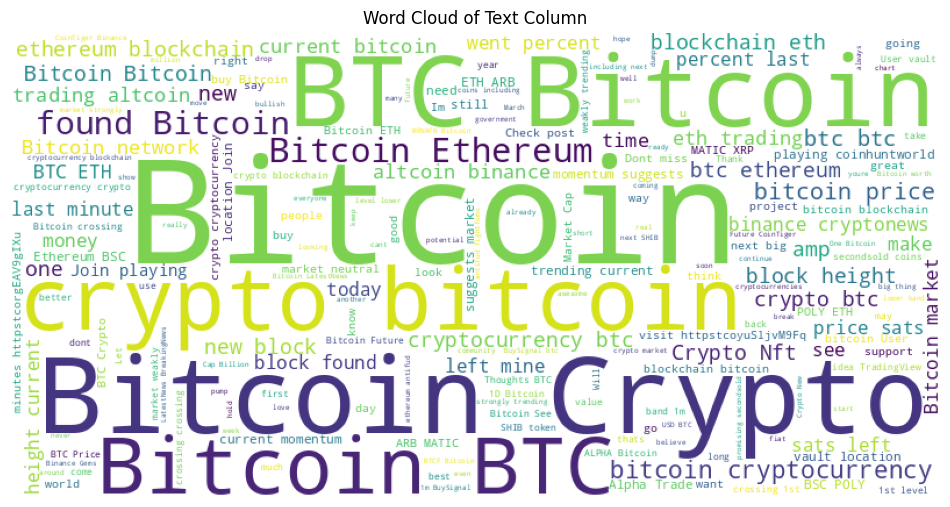

In [32]:
df_cleaned11 = df_cleaned.withColumn("text", concat_ws(" ", "text"))

text = df_cleaned11.select("text").rdd.flatMap(lambda x: x).collect()
text = " ".join(text)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud of Text Column")
plt.show()

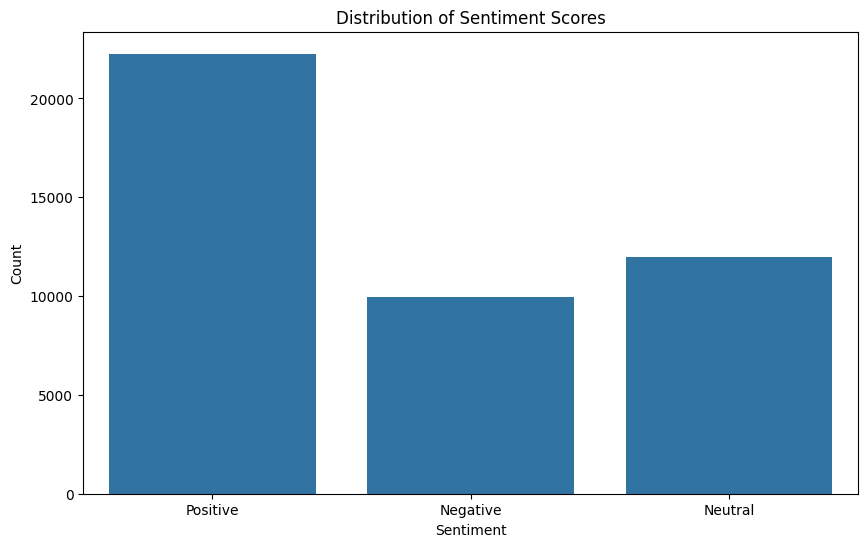

In [35]:
sentiment_counts = df_1.groupBy("sentiment_scored").count().toPandas()

sentiment_labels = {0: "Neutral", 1: "Positive", 2: "Negative"}
sentiment_counts['sentiment_label'] = sentiment_counts['sentiment_scored'].map(sentiment_labels)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment_label', y='count', data=sentiment_counts)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')
plt.show()

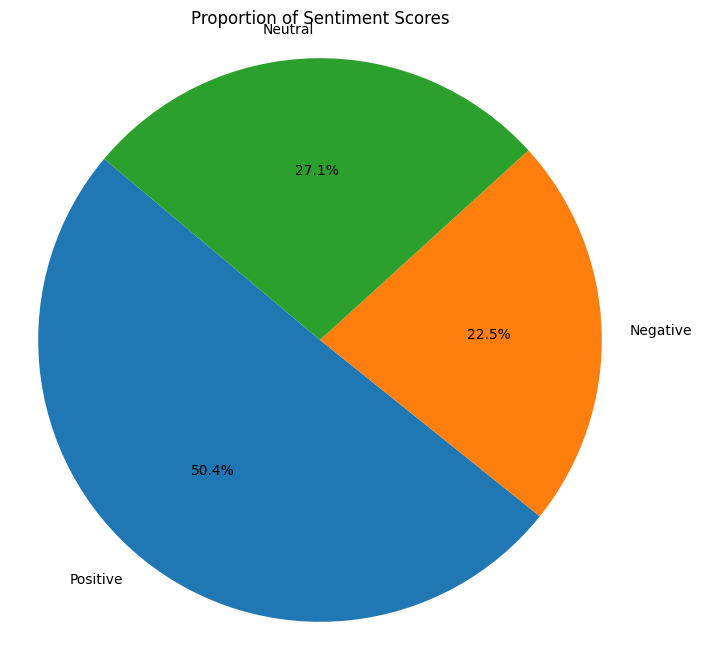

In [36]:
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts['count'], labels=sentiment_counts['sentiment_label'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Sentiment Scores')
plt.show()